In [3]:
import math
import datetime
import numpy as onp
import pandas as pd
import jax.numpy as np
from jax import grad, jit, vmap, jacfwd, jacrev
import jax.random as random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm, trange
tqdm.pandas()
import io
np.set_printoptions(precision=2)





rides = pd.read_csv('rideshare_trimmed.csv')
print('Done Uploading')

/usr/local/lib/python3.9/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Done Uploading


# Preprocessing data

In [4]:
rides = pd.read_csv('rideshare_trimmed.csv')
#print(rides)

In [5]:
rides

,Unnamed: 0,index,source,destination,cab_type,price,date
0,0,0,Haymarket Square,North Station,Lyft,5,2018-12-16
1,1,1,Haymarket Square,North Station,Lyft,10,2018-11-27
2,2,2,Haymarket Square,North Station,Lyft,5,2018-11-28
3,3,3,Haymarket Square,North Station,Lyft,25,2018-11-30
4,4,4,Haymarket Square,North Station,Lyft,5,2018-11-29
...,...,...,...,...,...,...,...
637971,637971,693065,West End,North End,Uber,5,2018-12-01
637972,637972,693066,West End,North End,Uber,10,2018-12-01
637973,637973,693067,West End,North End,Uber,5,2018-12-01
637974,637974,693069,West End,North End,Uber,25,2018-12-01


In [6]:
companies_ = rides.cab_type.unique()
sources_ = onp.delete(rides.source.unique(),9)
dates_ = rides.date.unique()[0:14]
prices_ = np.array([5+5*(i+1) for i in range(5)])

q = onp.zeros((len(companies_),len(dates_),len(sources_),len(prices_)))
avg_price = onp.zeros((len(companies_),len(dates_),len(sources_),len(prices_)))

for i in range(len(companies_)):
  for j in trange(len(dates_)):
    for k in range(len(sources_)):
      for l in range(len(prices_)):
        q[i,j,k,l] = len(rides[(rides['cab_type']==companies_[i])
                         &(rides['date']==dates_[j])
                         &(rides['source']==sources_[k])
                         &(rides['price']==prices_[l])])

100%|██████████| 14/14 [00:56<00:00,  4.06s/it]


In [7]:
prices_

DeviceArray([10, 15, 20, 25, 30], dtype=int32)

In [8]:
q_bar = np.mean(q,axis=1)

q_lyft = q[0]
q_uber = q[1]

q_bar_lyft = q_bar[0]
q_bar_uber = q_bar[1]

q_lyft_centered = (q_lyft-q_bar_lyft)
q_uber_centered = (q_uber-q_bar_uber)

q_bar_lyft = q_bar[0]
q_bar_uber = q_bar[1]
price_lst = prices_

## Loss and Oracles

In [9]:
@jit
def base_demand(q_centered, key, n=5):
  key, subkey = random.split(key)
  idx = random.randint(key,[n,q_centered.shape[1]],0,len(dates_))
  q = np.mean(q_lyft_centered[idx,[i for i in range(q_centered.shape[1])]],axis=0).reshape((-1,1))
  return q, key

@jit
def location_family_demand(q, theta_i, theta_j, mu_i, gamma_i):
  """
  Sample the demand for a ride with base demand q from the parametrized location family

  Input:
    q_i \in R^d_i, the base demand where q_i[k] is the demand for rides with features x_k
    theta_i \in R^d_i, the strategy for player i
    theta_j \in R^d_j, the strategy for player j
    mu_i \in R^{d_ixd_i}, the performative effects of player i on player i
    gamma_i \in R^{d_ixd_j}, the performative effects of player(s) -i on player i
  Output:
    demand \in R^d_i, the demand after performative effects for each x_k
  """
  demand = q + np.dot(mu_i,theta_i) + np.dot(gamma_i,theta_j)
  return demand

@jit
def loss(theta, demand_centered, avg_demand, prices, lambda_r):
  """
  Return the negative revenue loss for a particular theta_i and sampled demand

  Input:
    theta \in R^d_i, the player's strategy (price adjustments)
    demand \in R^d_i, the sampled demands for each of d sets of features x_k
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter
  Output:
    l \in R, the loss (-revenue + regularization)
  """
  l = -np.dot((avg_demand+demand_centered).T,prices+theta)+(lambda_r/2)*(np.sum(theta**2))
  return l[0,0]

@jit
def oracle_loss(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar):
  """
  Return 1 sample of the loss for a particular strategy profile and set of ride features
  Input:
    theta_i \in R^d_i, the strategy for player i
    theta_j \in R^d_j, the strategy for player j
    q_i \in R^d_i, the base demand where q_i[k] is the demand for rides with features x_k
    mu_i \in R^{d_ixd_i}, the performative effects of player i on player i
    gamma_i \in R^{d_ixd_j}, the performative effects of player(s) -i on player i
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter
    rides, the dataframe of rides
    x, a matrix describing the features of rides
  Output:
    l \in R, the loss (-revenue + regularization)
  """
  demand_centered = location_family_demand(q_centered,theta_i,theta_j,mu,gamma)
  l = loss(theta_i,demand_centered,q_bar,prices,lambda_r)
  return l

@jit
def oracle_gradient(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar):
  """
  Total gradient of the loss with respect to theta_i

  Input:
    theta_k \in R^d_k
    mu \in R^{d_ixd_i}
    gamma \in R^{d_ixd_j}
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter,
    rides, the dataframe of rides
    x, a matrix describing the features of rides
  Output:
    grad_l \in R^d_i, the gradient of the loss with respect to theta_i
  """
  grad_l = grad(oracle_loss)(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar)
  return grad_l

@jit
def oracle_hessian(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar):
  """
  Hessian of the loss with respect to theta_i

  Input:
    theta_k \in R^d_k
    mu \in R^{d_ixd_i}
    gamma \in R^{d_ixd_j}
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter,
    rides, the dataframe of rides
    x, a matrix describing the features of rides
  Output:
    grad_l \in R^d_ixd_i, the hessian of the loss with respect to theta_i
  """
  hessian_i = jacfwd(jacrev(oracle_loss))(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar)
  return hessian_i

@jit
def Pi_Theta(theta_i,R_i):
  """
  Project theta onto a 2-norm ball of radius R

  Input:
    theta_i \in R^d_i
    R_i \in R_+, the radius of Theta_i
  Output:
    Pi_Theta_i(theta_i), the projection of theta_i onto the ball of radius R_i
  """
  theta_clipped = np.clip(theta_i, a_min=-R_i, a_max=R_i)
  return theta_clipped

# Adaptive Gradient Play Implementation

In [10]:
@jit
def perturb_theta(B, key):
  """
  Sample a normal random vector u with covariance B

  Input:
    B \in S^d_+, the covariance of u
    key, a jax random number generator key 
  Output:
    u \in R^d, the injected noise
    key, a new jax random number generator key
  """
  d = B.shape[0]
  key, subkey = random.split(key)
  v = random.normal(subkey,shape=(d,1))
  u = np.dot(B,v)
  return u, key

@jit
def compute_q_hat(demand,mu_hat,gamma_hat,theta_i,theta_j,u_i,u_j):
  """
  Compute an estimate for q for one player

  Input:
    demand \in R^d_i, the sampled oracle demands for player i
    mu_hat \in R^d_i, the estimated mu for player i
    gamma_hat \in R^d_i, the estimated gamma for player i
    theta_k \in R^d_k, the strategy for player k
    u_k \in R^d_k, the perturbations for theta_k
  Output:
    q_hat \in R^d_i, the estimated base demands for player i
  """
  q_hat = demand - np.dot(mu_hat,theta_i+u_i) - np.dot(gamma_hat,theta_j+u_j)
  return q_hat

@jit
def update_p_hat(p_hat,demand,theta_i,theta_j,u_i,u_j,nu):
  """
  Update the estimate of p = [mu, gamma]

  Input:
  p_hat \in R^{d_ixd}, the previous estimate for p_hat
  demand \in R^d_i, the sampled demands for player i
  theta_k \in R^d_k
  u_k \in R^d_k
  nu \in R, stepsize
  """
  theta = np.vstack([theta_i,theta_j])
  u = np.vstack([u_i,u_j])
  p_hat_new = p_hat + nu*np.dot((demand-np.dot(p_hat,theta+u)),(theta+u).T)
  return p_hat_new

@jit
def grad_update(theta_i, theta_j, eta, q_hat, q_bar, p_hat, prices, lambda_r, R_i):
  """
  Individual gradient step for player i

  Input:
    theta_i \in R^d_i, the previous strategy for player i
    eta \in R, the step size
    gradient \in R^d_i, the gradient of the perturbed loss with respect to theta_i
    proj, a function that projects the updated theta_i onto Theta_i
  Output:
    theta_i_new \in R^d_i, the updated strategy for player i
  """
  d_i = np.shape(theta_i)[0]
  mu_hat, gamma_hat = np.split(p_hat, [d_i], axis=1)
  gradient = oracle_gradient(theta_i,theta_j,mu_hat,gamma_hat,prices,lambda_r,q_hat,q_bar)
  theta_i_new = Pi_Theta(theta_i - eta*gradient, R_i)
  return theta_i_new

# Adaptive Gradient Play

In [22]:
T = 1000
N = 2
key = random.PRNGKey(46)

d_1 = q_bar_uber.shape[1]
d_2 = q_bar_lyft.shape[1]
D = d_1+d_2
d_ = [d_1,d_2]

theta_1_total_history = []
q_1_total_history = []
q_1_hat_total_history = []
mu_1_hat_total_history = []
gamma_1_hat_total_history = []
grad_1_total_history = []
hessian_1_total_history = []
revenue_1_total_history = []

theta_2_total_history = []
q_2_total_history = []
q_2_hat_total_history = []
mu_2_hat_total_history = []
gamma_2_hat_total_history = []
grad_2_total_history = []
hessian_2_total_history = []
revenue_2_total_history = []

mu = []
gamma = []
q_bar = []

for source_idx in range(len(sources_)):
  # key, subkey = random.split(key)
  # noise1 = 2.0*random.normal(subkey,(d_1,d_2))
  # key, subkey = random.split(key)
  # noise2 = 2.0*random.normal(subkey,(d_1,d_2))

  mu.append([np.diagflat((-3*q_bar_uber[source_idx])/(2*np.array(price_lst))),
             np.diagflat((-3*q_bar_lyft[source_idx])/(2*np.array(price_lst)))])
  gamma.append([np.diagflat((3*q_bar_lyft[source_idx])/(4*np.array(price_lst))),
                np.diagflat((3*q_bar_uber[source_idx])/(4*np.array(price_lst)))])

  prices = [price_lst.reshape((-1,1)), price_lst.reshape((-1,1))]

  lambda_r = 0.02
  q_bar.append([q_bar_uber[source_idx].reshape((d_1,1)),
                q_bar_lyft[source_idx].reshape((d_2,1))])
  q_centered = [q_uber_centered[:,source_idx,:].squeeze(),
                q_lyft_centered[:,source_idx,:].squeeze()]
  q = [np.zeros((d_1,1)), np.zeros((d_2,1))]

  theta = [np.zeros((d_1,1)), np.zeros((d_2,1))]
  u = [np.zeros((d_1,1)), np.zeros((d_2,1))]
  mu_hat = [np.diagflat(np.zeros(d_1)), np.diagflat(np.zeros(d_2))]
  gamma_hat = [np.diagflat(np.zeros(d_2)), np.diagflat(np.zeros(d_1))]
  p_hat = [np.zeros((d_1,D)), np.zeros((d_2,D))]
  q_hat = [np.zeros((d_1,1)), np.zeros((d_2,1))]
  z_t = [np.zeros((d_1,1)), np.zeros((d_2,1))]

  B = [5.0*np.eye(d_1), 5.0*np.eye(d_2)]
  eta = [5e-3, 5e-3]
  k = [0.005, 0.005]
  nu = [1e-3, 1e-3]

  R = 1e6

  theta_1_history = []
  q_1_history = []
  q_1_hat_history = []
  mu_1_hat_history = []
  gamma_1_hat_history = []
  grad_1_history = []
  hessian_1_history = []
  revenue_1_history = []

  theta_2_history = []
  q_2_history = []
  q_2_hat_history = []
  mu_2_hat_history = []
  gamma_2_hat_history = []
  grad_2_history = []
  hessian_2_history = []
  revenue_2_history = []

  for t in trange(T):
    for i in [0,1]:
      j = (i+1)%2
      u[i], key = perturb_theta(B[i], key)
      q[i], key = base_demand(q_centered[i][source_idx].reshape((-1,1)), key)

    for i in [0,1]:
      j = (i+1)%2
      z_t[i] = location_family_demand(q[i],theta[i]+u[i],theta[j]+u[j],mu[source_idx][i],gamma[source_idx][i])
      q_hat[i] = compute_q_hat(z_t[i],mu_hat[i],gamma_hat[i],theta[i],theta[j],u[i],u[j])
      p_hat[i] = update_p_hat(p_hat[i],z_t[i],theta[i],theta[j],u[i],u[j],(nu[i]/(1+k[i]*t)))
      mu_hat[i], gamma_hat[i] = np.split(p_hat[i], [d_[i]], axis=1)
      #print(np.shape(p_hat[i]), np.shape(mu_hat[i]), np.shape(gamma_hat[i]))
      if i == 0:
          p_hat[i] = np.hstack((mu_hat[i],0*gamma_hat[i]))
      theta[i] = grad_update(theta[i],theta[j],(eta[i]/(1+k[i]*t)),q_hat[i],q_bar[source_idx][i],p_hat[i],prices[i],lambda_r,R)
      rev = oracle_loss(theta[i],theta[j],mu_hat[i],gamma_hat[i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[source_idx][i])
      # gradient_t = oracle_gradient(theta[i],theta[j],mu_hat[i],gamma_hat[i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[source_idx][i])
      # hessian_t = oracle_hessian(theta[i],theta[j],mu_hat[i],gamma_hat[i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[i])
      if i==0:
        q_1_history.append(q[i])
        q_1_hat_history.append(q_hat[i])
        mu_1_hat_history.append(mu_hat[i])
        gamma_1_hat_history.append(gamma_hat[i])
        theta_1_history.append(theta[i])
        revenue_1_history.append(-rev)
        # grad_1_history.append(gradient_t)
        # hessian_1_history.append(hessian_t)
      else:
        q_2_history.append(q[i])
        q_2_hat_history.append(q_hat[i])
        mu_2_hat_history.append(mu_hat[i])
        gamma_2_hat_history.append(gamma_hat[i])
        theta_2_history.append(theta[i])
        revenue_2_history.append(-rev)
        # grad_2_history.append(gradient_t)
        # hessian_2_history.append(hessian_t)

  theta_1_total_history.append(theta_1_history)
  q_1_total_history.append(q_1_history)
  q_1_hat_total_history.append(q_1_hat_history)
  mu_1_hat_total_history.append(mu_1_hat_history)
  gamma_1_hat_total_history.append(gamma_1_hat_history)
  revenue_1_total_history.append(revenue_1_history)
  # grad_1_total_history.append(grad_1_history)
  # hessian_1_total_history.append(hessian_1_history)

  theta_2_total_history.append(theta_2_history)
  q_2_total_history.append(q_2_history)
  q_2_hat_total_history.append(q_2_hat_history)
  mu_2_hat_total_history.append(mu_2_hat_history)
  gamma_2_hat_total_history.append(gamma_2_hat_history)
  revenue_2_total_history.append(revenue_2_history)
  # grad_2_total_history.append(grad_2_history)
  # hessian_2_total_history.append(hessian_2_history)

100%|██████████| 1000/1000 [00:06<00:00, 158.58it/s]


# Adaptive Gradient Play Plots

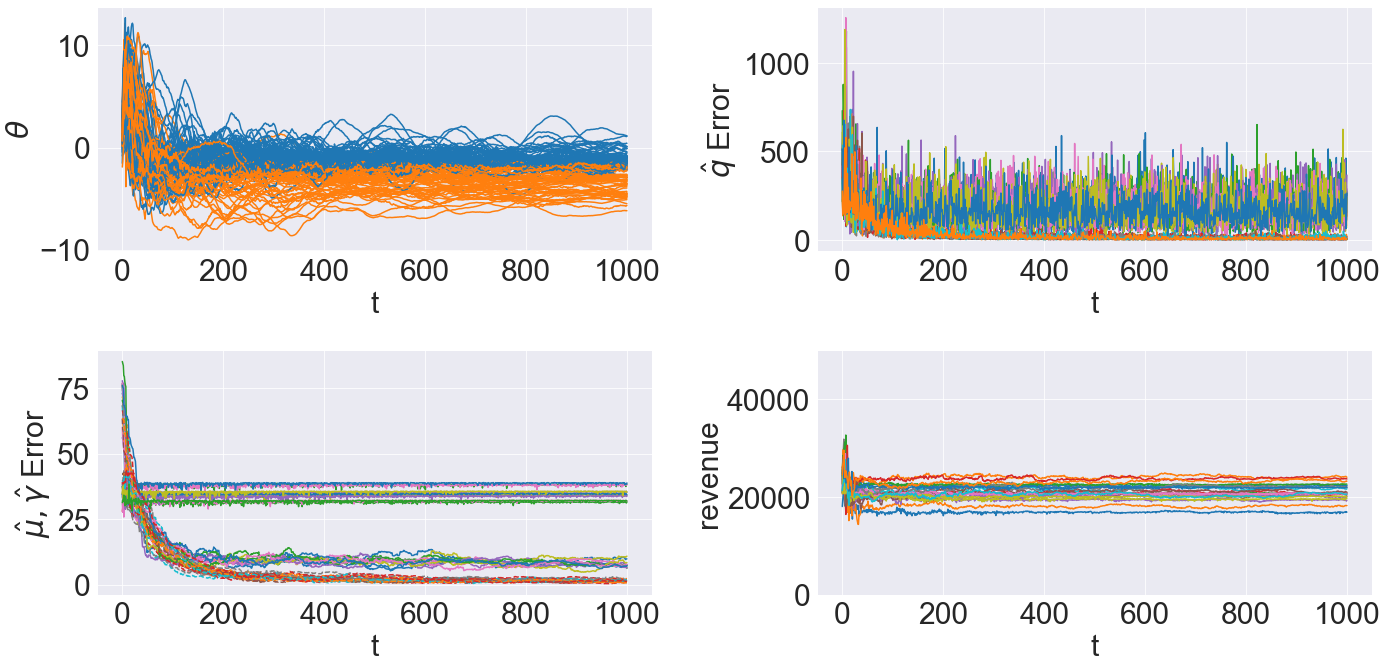

In [23]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))

for source_idx in range(len(sources_)):

  q_1_error = [np.linalg.norm(q_1_hat_total_history[source_idx][i]-q_1_total_history[source_idx][i]) for i in range(len(q_1_hat_total_history[source_idx]))]
  q_2_error = [np.linalg.norm(q_2_hat_total_history[source_idx][i]-q_2_total_history[source_idx][i]) for i in range(len(q_2_hat_total_history[source_idx]))]
  mu_1_error = [np.linalg.norm(mu_1_hat_total_history[source_idx][i]-mu[source_idx][0]) for i in range(len(mu_1_hat_total_history[source_idx]))]
  gamma_1_error = [np.linalg.norm(gamma_1_hat_total_history[source_idx][i]-gamma[source_idx][0]) for i in range(len(gamma_1_hat_total_history[source_idx]))]
  mu_2_error = [np.linalg.norm(mu_2_hat_total_history[source_idx][i]-mu[source_idx][1]) for i in range(len(mu_2_hat_total_history[source_idx]))]
  gamma_2_error = [np.linalg.norm(gamma_2_hat_total_history[source_idx][i]-gamma[source_idx][1]) for i in range(len(gamma_2_hat_total_history[source_idx]))]

  ax1.plot(np.linspace(0,T,T),np.array(theta_1_total_history[source_idx]).squeeze(),label=r'$\theta_1$',color='tab:blue')
  ax1.plot(np.linspace(0,T,T),np.array(theta_2_total_history[source_idx]).squeeze(),label=r'$\theta_2$',color='tab:orange')
  ax1.set_xlabel('t')
  ax1.set_ylabel(r'$\theta$')
  ax2.plot(np.linspace(0,T,T),q_1_error,label=r'$||\hat{q}_1-q_1||$')
  ax2.plot(np.linspace(0,T,T),q_2_error,label=r'$||\hat{q}_2-q_2||$')
  ax2.set_xlabel('t')
  ax2.set_ylabel(r'$\hat{q}$ Error')
  # ax2.legend()
  ax3.plot(np.linspace(0,T,T),mu_1_error,label=r'$||\hat{\mu}_1-\mu_1||$')
  ax3.plot(np.linspace(0,T,T),mu_2_error,'--',label=r'$||\hat{\mu}_2-\mu_2||$')
  ax3.plot(np.linspace(0,T,T),gamma_1_error,label=r'$||\hat{\gamma}_1-\gamma_1||$')
  ax3.plot(np.linspace(0,T,T),gamma_2_error,'--',label=r'$||\hat{\gamma}_2-\gamma_2||$')
  ax3.set_xlabel('t')
  ax3.set_ylabel(r'$\hat{\mu},\hat{\gamma}$ Error')
  ax4.plot(np.linspace(0,T,T),revenue_1_total_history[source_idx],label=r'revenue uber')
  ax4.plot(np.linspace(0,T,T),revenue_2_total_history[source_idx],label=r'revenue lyft')
  ax4.set_xlabel('t')
  ax4.set_ylabel(r'revenue')
  ax4.set_ylim(0,50000)
  # ax4.legend()

plt.tight_layout()
plt.show()

## SGD With Sampling Bias

In [10]:
T = 1000
N = 2
key = random.PRNGKey(46)

theta_1_sgd_total_history = []
theta_2_sgd_total_history = []

for source_idx in range(len(sources_)):
  theta_sgd = [np.zeros((d_1,1)), np.zeros((d_2,1))]
  eta = [5e-3, 5e-3]
  k = [0.005, 0.005]
  p = [np.hstack([mu[source_idx][0],gamma[source_idx][0]]), np.hstack([mu[source_idx][1],gamma[source_idx][1]])]
  R = 1e6

  theta_1_sgd_history = []
  theta_2_sgd_history = []

  for t in trange(T):
    for i in [0,1]:
      j = (i+1)%2
      q[i], key = base_demand(q_centered[i][source_idx].reshape((-1,1)), key)
      theta_sgd[i] = grad_update(theta_sgd[i],theta_sgd[j],(eta[i]/(1+k[i]*t)),q[i],q_bar[source_idx][i],p[i],prices[i],lambda_r,R)
      if i==0:
        theta_1_sgd_history.append(theta_sgd[i])
      else:
        theta_2_sgd_history.append(theta_sgd[i])
  theta_1_sgd_total_history.append(theta_1_sgd_history)
  theta_2_sgd_total_history.append(theta_2_sgd_history)

100%|██████████| 1000/1000 [00:02<00:00, 380.55it/s]


# SGD Plots

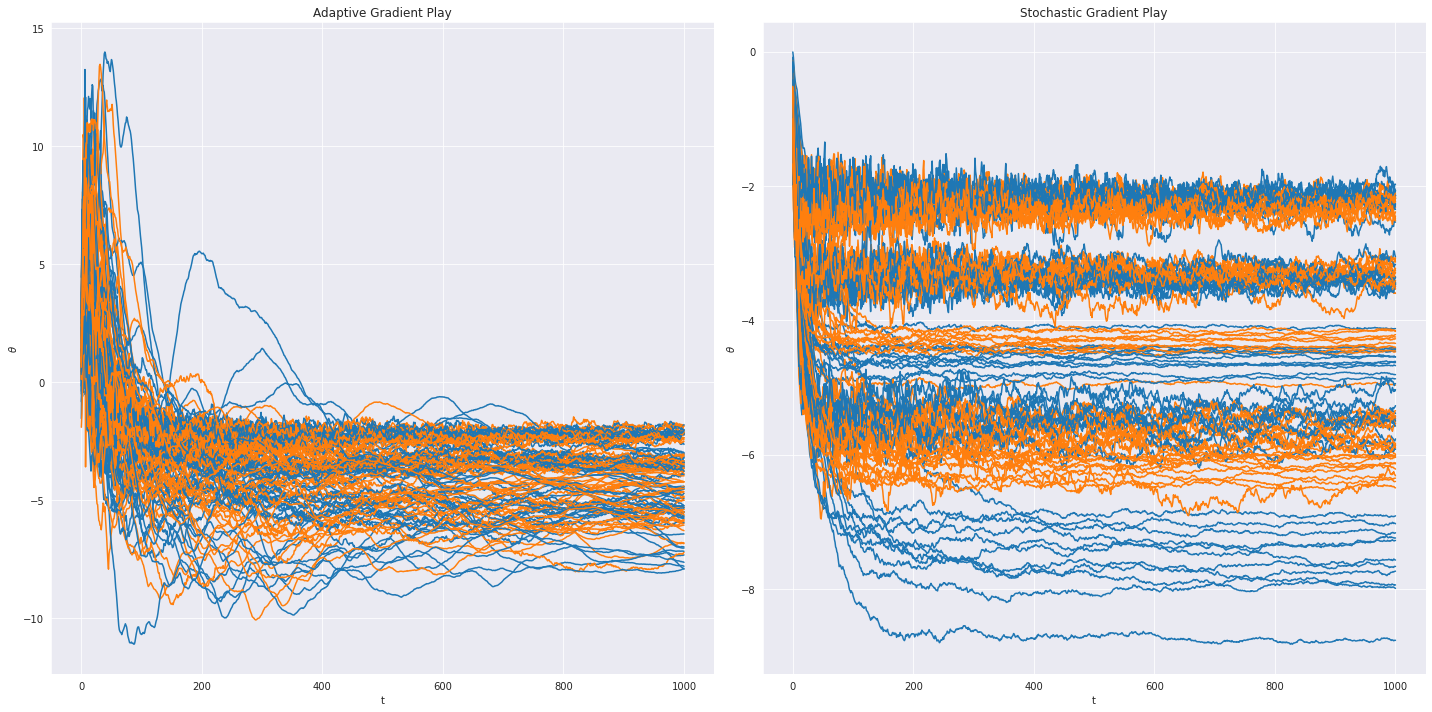

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
for source_idx in range(len(sources_)):
  ax1.plot(np.linspace(0,T,T),np.array(theta_1_total_history[source_idx]).squeeze(),label=r'$\theta_1$',color='tab:blue')
  ax1.plot(np.linspace(0,T,T),np.array(theta_2_total_history[source_idx]).squeeze(),label=r'$\theta_2$',color='tab:orange')
  # ax1.set_ylim(-10,10)
  ax1.set_xlabel('t')
  ax1.set_ylabel(r'$\theta$')
  ax1.set_title('Adaptive Gradient Play')
  # ax1.legend()
  ax2.plot(np.linspace(0,T,T),np.array(theta_1_sgd_total_history[source_idx]).squeeze(),label=r'$\theta_1$',color='tab:blue')
  ax2.plot(np.linspace(0,T,T),np.array(theta_2_sgd_total_history[source_idx]).squeeze(),label=r'$\theta_2$',color='tab:orange')
  # ax2.set_ylim(-10,10)
  ax2.set_xlabel('t')
  ax2.set_ylabel(r'$\theta$')
  ax2.set_title('Stochastic Gradient Play')
  # ax2.legend()
plt.tight_layout()
plt.show()

In [24]:
theta_uber_nash = onp.zeros((len(prices_),len(sources_)))
theta_lyft_nash = onp.empty((len(prices_),len(sources_)))

for i in range(len(sources_)):
  theta_uber_nash[:,i] = onp.array(theta_1_total_history[i][-1].squeeze())
  theta_lyft_nash[:,i] = onp.array(theta_2_total_history[i][-1].squeeze())


print(theta_uber_nash)
print(theta_lyft_nash)

[[-0.78 -1.28 -2.   -0.95 -1.43 -1.   -1.34 -1.51 -1.06 -0.94 -1.54]
 [-1.66 -1.29 -1.36 -1.13 -1.81 -1.59 -1.1  -1.74 -1.49 -2.18 -1.35]
 [ 0.06 -1.57  1.11 -0.43 -0.08 -1.25 -0.87 -0.91 -1.3  -1.55 -0.08]
 [-1.84 -1.74 -0.45  0.11 -2.15 -0.12 -1.65 -1.83 -1.46 -1.19 -0.56]
 [-2.03 -2.92  1.14 -0.98  0.11  0.41 -0.91 -0.85 -0.78 -1.81 -1.08]]
[[-1.58 -2.01 -2.19 -1.9  -1.73 -1.94 -2.02 -2.29 -1.78 -1.87 -2.2 ]
 [-3.25 -2.93 -2.94 -2.73 -2.76 -3.31 -2.63 -3.18 -2.97 -4.41 -2.86]
 [-4.29 -3.44 -3.1  -2.63 -3.19 -2.74 -3.14 -3.53 -4.56 -3.59 -3.71]
 [-4.81 -4.69 -3.79 -4.5  -5.68 -3.54 -4.52 -4.78 -3.6  -4.62 -4.73]
 [-6.18 -2.8  -2.91 -4.96 -2.99 -5.1  -3.95 -3.29 -5.5  -4.55 -4.88]]


# Nash Conditions

In [25]:
for k in range(len(sources_)):
  for i in range(2):
    j = (i+1)%2
    theta_nash = [theta_1_sgd_total_history[k][-1], theta_2_sgd_total_history[k][-1]]
    print(f'Origin = {sources_[k]}')
    print(f'Player {i+1}')
    print('Gradient R(theta_{SGD}) = ','\n',oracle_gradient(theta_nash[i],theta_nash[j],mu[k][i],gamma[k][i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[k][i]))
    print('Hessian R(theta_{SGD}) = ','\n',oracle_hessian(theta_nash[i],theta_nash[j],mu[k][i],gamma[k][i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[k][i]).squeeze())
    print(f'Hessian Eigvals SGD = {np.linalg.eigvals(oracle_hessian(theta_nash[i],theta_nash[j],mu[k][i],gamma[k][i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[k][i]).squeeze())}')

NameError: name 'theta_1_sgd_total_history' is not defined

# Plots

/usr/local/lib/python3.9/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
<ipython-input-26-881e488cc9bd>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  a0.set_xticklabels([' ' for x in a0.get_xticks()],fontsize=30)


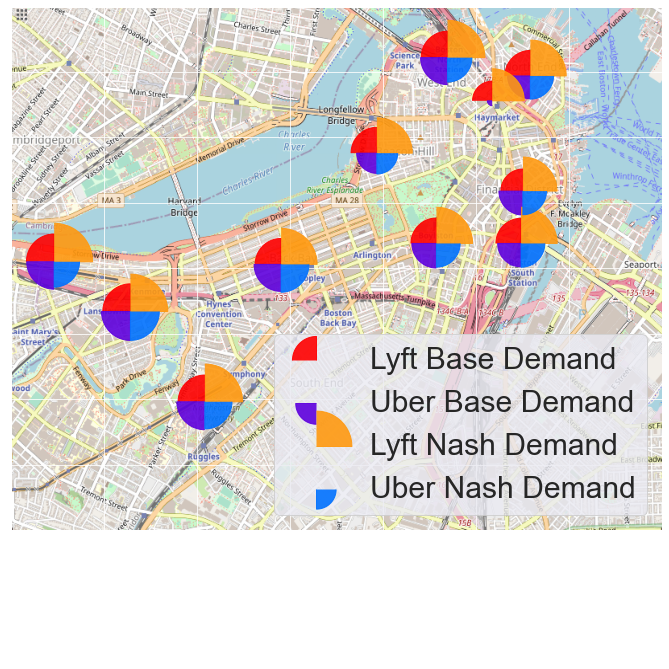

In [26]:
plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 1
locations = {'Haymarket Square':(42.3628, -71.0583), 'Back Bay':(42.3503, -71.0810),
             'North End':(42.3647, -71.0542), 'North Station':(42.3661, -71.0631),
             'Beacon Hill':(42.3588, -71.0707), 'Boston University':(42.3505, -71.1054),
             'Fenway':(42.3467, -71.0972), 'South Station':(42.3519, -71.0552),
             'Theatre District':(42.3519, -71.0643),# 'West End':(42.3644, -71.0661),
             'Financial District':(42.3559, -71.0550), 'Northeastern University':(42.3398, -71.0892)}

shift = 4900
uber_nash_demand = onp.zeros(len(sources_))
uber_base_demand = onp.zeros(len(sources_))
lyft_nash_demand = onp.zeros(len(sources_))
lyft_base_demand = onp.zeros(len(sources_))
for i in range(len(sources_)):
  uber_nash_demand[i] = np.sum(location_family_demand(q_bar_uber[i],theta_uber_nash[:,i].reshape((-1,1)),theta_lyft_nash[:,i].reshape((-1,1)), mu[i][0],gamma[i][0]))-shift
  lyft_nash_demand[i] = np.sum(location_family_demand(q_bar_lyft[i],theta_lyft_nash[:,i].reshape((-1,1)),theta_uber_nash[:,i].reshape((-1,1)), mu[i][1],gamma[i][1]))-shift
  uber_base_demand[i] = np.sum(location_family_demand(q_bar_uber[i],np.zeros((d_1,1)),np.zeros((d_2,1)), mu[i][0],gamma[i][0]))-shift
  lyft_base_demand[i] = np.sum(location_family_demand(q_bar_lyft[i],np.zeros((d_2,1)),np.zeros((d_1,1)), mu[i][1],gamma[i][1]))-shift

sources = []
lats = []
lons = []
for source, coord in locations.items():
    sources.append(source)
    lats.append(coord[0])
    lons.append(coord[1])

r1 = 1
x1 = onp.cos(onp.pi/2 * onp.linspace(0, r1))
y1 = onp.sin(onp.pi/2 * onp.linspace(0, r1))
uright_c = onp.row_stack([[0, 0], onp.column_stack([x1, y1])])
x1 = onp.cos(onp.pi/2 * onp.linspace(0, r1)+onp.pi/2)
y1 = onp.sin(onp.pi/2 * onp.linspace(0, r1)+onp.pi/2)
uleft_c = onp.row_stack([[0, 0], onp.column_stack([x1, y1])])
x1 = onp.cos(onp.pi/2 * onp.linspace(0, r1)-onp.pi/2)
y1 = onp.sin(onp.pi/2 * onp.linspace(0, r1)-onp.pi/2)
lright_c = onp.row_stack([[0, 0], onp.column_stack([x1, y1])])
x1 = onp.cos(onp.pi/2 * onp.linspace(0, r1)+onp.pi)
y1 = onp.sin(onp.pi/2 * onp.linspace(0, r1)+onp.pi)
lleft_c = onp.row_stack([[0, 0], onp.column_stack([x1, y1])])

scale = 2
a = 0.9

f,a0 = plt.subplots(figsize=(10,10))
im = plt.imread('boston_map.PNG')
a0.imshow(im, extent=[-71.1100, -71.0400, 42.3300, 42.3700], aspect='auto')
a0.scatter(lons, lats, marker=uleft_c, s=scale*lyft_base_demand, alpha=a, c='#FF0000', label='Lyft Base Demand')
a0.scatter(lons, lats, marker=lleft_c, s=scale*uber_base_demand, alpha=a, c='#5E00DD', label='Uber Base Demand')
a0.scatter(lons, lats, marker=uright_c, s=scale*lyft_nash_demand, alpha=a, c='#FF9910', label='Lyft Nash Demand')
a0.scatter(lons, lats, marker=lright_c, s=scale*uber_nash_demand, alpha=a, c='#0071FF', label='Uber Nash Demand')
a0.set_xticklabels([' ' for x in a0.get_xticks()],fontsize=30)
a0.set_yticklabels([],fontsize=0)
a0.set_xlabel(' \n  \n')
a0.legend(loc='lower right', prop={'size': 30})
f.tight_layout()
plt.savefig("rideshare_demand_map.png", format='png')
plt.show()

In [27]:
uber_nash_revenue = onp.zeros(len(sources_))
lyft_nash_revenue = onp.zeros(len(sources_))
uber_base_revenue = onp.zeros(len(sources_))
lyft_base_revenue = onp.zeros(len(sources_))

for i in range(len(sources_)):
  uber_nash_revenue[i] = oracle_loss(theta_uber_nash[:,i].reshape((-1,1)),theta_lyft_nash[:,i].reshape((-1,1)),mu[i][0],gamma[i][0],prices_,lambda_r,np.zeros((d_1,1)),q_bar[i][0])
  uber_base_revenue[i] = oracle_loss(np.zeros((d_1,1)),np.zeros((d_2,1)),mu[i][0],gamma[i][0],prices_,lambda_r,np.zeros((d_1,1)),q_bar[i][0])
  lyft_nash_revenue[i] = oracle_loss(theta_uber_nash[:,i].reshape((-1,1)),theta_lyft_nash[:,i].reshape((-1,1)),mu[i][0],gamma[i][0],prices_,lambda_r,np.zeros((d_2,1)),q_bar[i][1])
  lyft_base_revenue[i] = oracle_loss(np.zeros((d_1,1)),np.zeros((d_2,1)),mu[i][1],gamma[i][1],prices_,lambda_r,np.zeros((d_2,1)),q_bar[i][1])

print(uber_nash_revenue)
print(uber_base_revenue)
print(lyft_nash_revenue)
print(lyft_base_revenue)

[ -8200.57 -10946.12 -10456.76 -11246.14  -9786.46 -11239.22 -11544.34
 -10188.01 -10503.79 -10298.84 -11291.45]
[ -9895.   -12718.57 -11870.71 -12709.29 -11434.29 -12810.71 -13151.43
 -11982.86 -12212.86 -12097.86 -12930.  ]
[ -9553.38 -10715.66 -11065.19 -11126.38 -10967.15 -11374.12 -11314.89
 -10545.83 -10694.35 -10039.53 -11119.57]
[-11345.   -12488.57 -12404.29 -12591.43 -12467.86 -12881.43 -12855.
 -12330.   -12389.29 -11741.43 -12655.71]


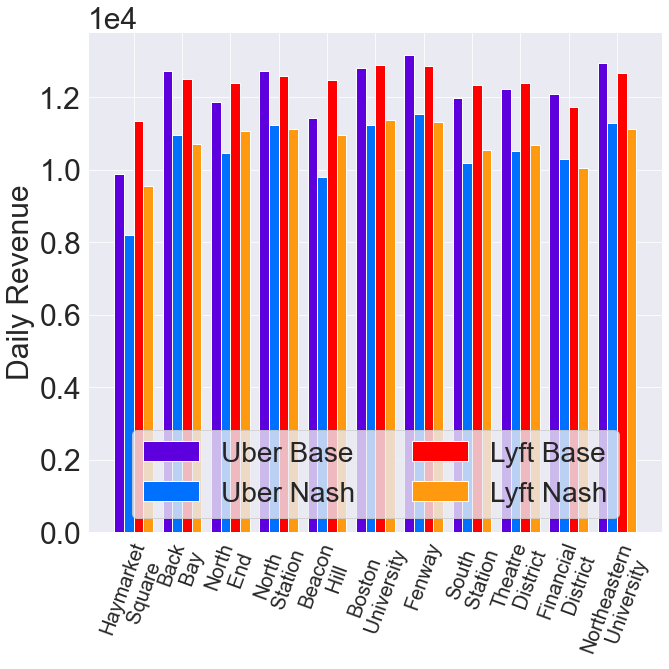

In [28]:
plt.rcParams['font.size'] = 30
plt.rcParams['axes.linewidth'] = 1
labels = [s.replace(' ','\n ') for s in sources_]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x-3*width/2, -uber_base_revenue, width, label='Uber Base', color='#5E00DD')
ax.bar(x-width/2, -uber_nash_revenue, width, label='Uber Nash', color='#0071FF')
ax.bar(x+width/2, -lyft_base_revenue, width, label='Lyft Base', color='#FF0000')
ax.bar(x+3*width/2, -lyft_nash_revenue, width, label='Lyft Nash', color='#FF9910')

ax.set_ylabel('Daily Revenue')
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=20)
# ax.set_ylim(0,18000)
plt.xticks(rotation=90)
ax.legend(fontsize=28, loc='lower center', ncol=2)
plt.xticks(rotation=70)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.savefig('rideshare_revenue.png', format='png')
plt.show()

In [18]:
total_base = onp.sum(uber_base_revenue)+onp.sum(lyft_base_revenue)
uber_base_share = onp.sum(uber_base_revenue)/total_base
total_nash = onp.sum(uber_nash_revenue)+onp.sum(lyft_nash_revenue)
uber_nash_share = onp.sum(uber_nash_revenue)/total_nash
print(uber_base_share)
print(uber_nash_share)

0.4956726983323235
0.5018641704032354
